# Flowing Bottom Hole Pressure (FBHP) Calculation Showcase
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Production Data Analysis (RTA/DCA)

## 1. Introduction
Calculating FBHP is a fundamental task in production engineering. It involves solving the general energy equation for fluid flow in a pipe.

In this notebook, we will:
1.  Load well test data (Rates, Surface Pressure, Geometry).
2.  Define PVT functions to estimate fluid properties (Density, Viscosity, Z-factor).
3.  Implement a **Pressure Traverse Algorithm** to integrate pressure from the surface down to the reservoir depth.

The governing equation for the pressure gradient ($dP/dZ$) is:

$$\frac{dP}{dz} = \frac{g}{g_c} \rho_m \sin(\theta) + \frac{f \rho_m v_m^2}{2 g_c D}$$

Where:
* $\rho_m$: Mixture density (accounting for gas/liquid holdup)
* $f$: Friction factor
* $v_m$: Mixture velocity
* $D$: Tubing Diameter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration for plotting
plt.style.use('ggplot')

# Load the dataset
df = pd.read_csv('well_test_data.csv')
print(f"Dataset loaded: {df.shape[0]} records")
df.head()

Dataset loaded: 500 records


,Well_ID,Qo_bpd,Qw_bpd,Qg_mscfd,P_wh_psi,T_wh_f,API_gravity,SG_gas,Depth_ft,Tubing_ID_in,T_res_f
0,WELL-001,624.356166,349.080857,411.009211,331.678625,90.468227,42.412784,0.750905,5859.558647,2.992,178.361607
1,WELL-002,1431.000029,268.048183,1106.706847,317.713657,89.879152,41.467917,0.769502,7407.920937,2.441,200.997966
2,WELL-003,1124.791519,154.763808,1752.244380,158.974723,116.250183,38.602934,0.687570,7991.713700,2.441,236.125889
3,WELL-004,938.121878,406.897510,1477.838528,269.436740,89.981848,44.340707,0.743731,5090.078016,3.958,166.333018
4,WELL-005,318.426097,342.365586,1622.794238,283.068467,90.877989,33.007118,0.735762,7692.097597,3.958,206.259453


## 2. Fundamental PVT Correlations
To calculate pressure drop, we first need to know the properties of the fluid at various pressures and temperatures. Since we don't have lab data for every well, we use empirical correlations.

We will define helper functions for:
* **Z-Factor (Gas Compressibility):** Hall-Yarborough method approximation.
* **Gas Formation Volume Factor ($B_g$):** Relates surface volume to downhole volume.
* **Solution Gas Oil Ratio ($R_s$):** Vazquez-Beggs correlation.

In [3]:
def calc_z_factor(P, T):
    """
    Simplified constant Z-factor for demonstration.
    In a full production scenario, use Dranchuk-Abou-Kassem correlation.
    """
    return 0.9

def calc_bg(P, T, z):
    """
    Calculate Gas Formation Volume Factor (Bg) in bbl/scf
    P in psi, T in Rankine
    """
    if P == 0: return 0
    # Bg = 0.02827 * z * T / P (cu ft/scf) -> converted to bbl/scf
    return 0.005035 * z * T / P

def calc_rs(P, api, sg_gas, T):
    """
    Simplified Solution GOR (Rs) using a linear approximation for the showcase.
    """
    # Placeholder for Vazquez-Beggs
    return 0.03 * P * (10**(0.0125*api))

## 3. Pressure Gradient Logic (The Engine)
This is the core of the calculation. We divide the wellbore into small segments (e.g., 100 increments). For each segment, we:
1.  Assume a pressure drop.
2.  Calculate average pressure and temperature in the segment.
3.  Calculate fluid properties (Densities, Viscosities, Hold-up) at that average.
4.  Calculate the friction and elevation gradients.
5.  Update the pressure.

*Note: For this showcase, we assume a simplified **No-Slip** (Homogeneous) model to demonstrate the integration loop clearly using NumPy.*

In [4]:
def calculate_pressure_traverse(row, n_steps=50):
    """
    Performs iteration from surface to bottom hole.
    Returns: FBHP (psi) and the pressure_profile list for plotting.
    """
    # 1. Initialize Surface Conditions
    depth_total = row['Depth_ft']
    p_current = row['P_wh_psi']
    t_current = row['T_wh_f'] + 460 # Convert to Rankine
    
    # Well Geometry & Rates
    d_in = row['Tubing_ID_in']
    area_sqft = (np.pi/4) * (d_in/12)**2
    
    qo = row['Qo_bpd']
    qg = row['Qg_mscfd'] * 1000
    qw = row['Qw_bpd']
    
    # Temperature Gradient
    temp_grad = (row['T_res_f'] - row['P_wh_psi']) / depth_total # Simplified
    
    # Step size
    dz = depth_total / n_steps
    
    depths = [0]
    pressures = [p_current]
    
    # 2. Integration Loop (Top-Down)
    for i in range(n_steps):
        # Estimate conditions at mid-point of segment
        t_mid = t_current + (temp_grad * dz / 2)
        p_guess = p_current + 10 # Initial guess for gradient
        
        # --- PVT Section ---
        z = calc_z_factor(p_guess, t_mid)
        bg = calc_bg(p_guess, t_mid, z)
        rs = calc_rs(p_guess, row['API_gravity'], row['SG_gas'], t_mid)
        bo = 1.0 + 0.0001 * (p_guess - 14.7) # Simplified Bo
        bw = 1.0
        
        # --- Rates at Downhole Conditions ---
        # Free gas = Total Gas - Dissolved Gas
        qg_dissolved = qo * rs
        qg_free = max(0, qg - qg_dissolved)
        
        # Volumetric Flow Rates (bbl/day -> ft3/sec)
        conv_bbl_day_to_cfs = 5.615 / 86400
        conv_scf_day_to_cfs = 1 / 86400 # Bg handles the volume conversion
        
        qo_down = qo * bo * conv_bbl_day_to_cfs
        qw_down = qw * bw * conv_bbl_day_to_cfs
        qg_down = qg_free * bg * (1/86400) # Bg is usually bbl/scf, need consistency
        
        q_total = qo_down + qw_down + qg_down
        vm = q_total / area_sqft # Mixture Velocity
        
        # --- Density Section (No-Slip) ---
        # Calculate liquid fraction (Holdup approximation)
        lambda_l = (qo_down + qw_down) / q_total
        
        rho_o = 62.4 * 0.8 # approx oil density
        rho_w = 62.4 * 1.0 # water density
        rho_g = 2.0 # approx gas density at pressure
        
        rho_mix = (lambda_l * rho_o) + (lambda_l * rho_w) + ((1-lambda_l) * rho_g)
        
        # --- Pressure Gradient Calculation ---
        # 1. Elevation Term (Hydrostatic)
        # dP/dZ_elev = density (lb/ft3) 
        grad_elev = rho_mix # psi/ft = lb/ft3 / 144
        
        # 2. Friction Term (Darcy-Weisbach simplified)
        # Using a fixed friction factor for demo
        f = 0.02 
        grad_fric = (f * rho_mix * vm**2) / (2 * 32.2 * (d_in/12))
        
        # Total Gradient (psi/ft)
        # Note: Divide by 144 to convert lb/ft2 to psi
        total_grad = (grad_elev + grad_fric) / 144
        
        # Update Pressure
        dp = total_grad * dz
        p_current += dp
        t_current += (temp_grad * dz)
        
        depths.append((i+1)*dz)
        pressures.append(p_current)
        
    return p_current, depths, pressures

## 4. Execution and Visualization
Now we apply the calculation to our dataset and visualize the pressure profile for a specific well.

Well: WELL-001
Wellhead Pressure: 331.6786247976763 psi
Calculated FBHP: 4592.47 psi


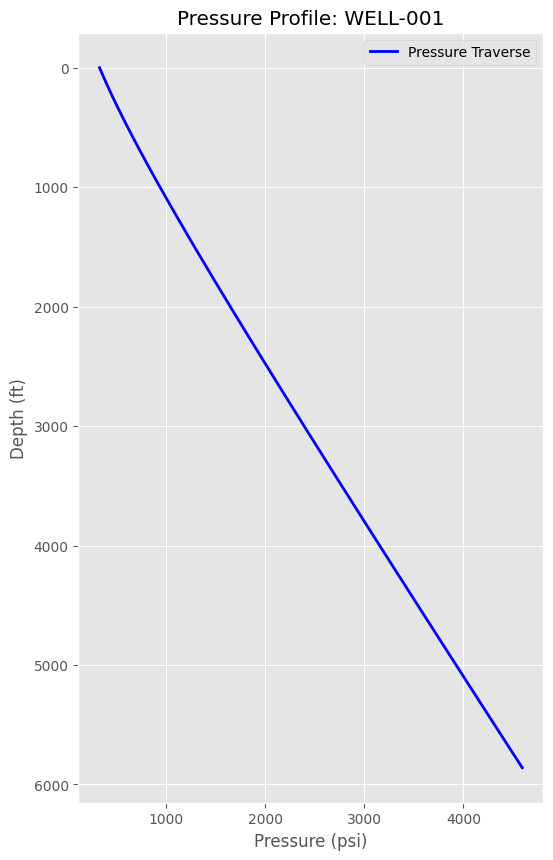

In [5]:
# 1. Calculate FBHP for a single sample well
sample_well = df.iloc[0]
fbhp, depth_prof, press_prof = calculate_pressure_traverse(sample_well)

print(f"Well: {sample_well['Well_ID']}")
print(f"Wellhead Pressure: {sample_well['P_wh_psi']} psi")
print(f"Calculated FBHP: {fbhp:.2f} psi")

# 2. Visualization
plt.figure(figsize=(6, 10))
plt.plot(press_prof, depth_prof, label='Pressure Traverse', color='blue', linewidth=2)
plt.gca().invert_yaxis() # Depth increases downwards
plt.title(f"Pressure Profile: {sample_well['Well_ID']}")
plt.xlabel("Pressure (psi)")
plt.ylabel("Depth (ft)")
plt.grid(True)
plt.legend()
plt.show()

## 5. Batch Processing
We can now apply this function to the entire dataset to generate the `FBHP_Calculated` column.

In [6]:
# Apply to all rows
# Note: This might take a few seconds
results = df.apply(lambda row: calculate_pressure_traverse(row)[0], axis=1)
df['FBHP_Calc'] = results

# Show comparison
df[['Well_ID', 'P_wh_psi', 'Depth_ft', 'FBHP_Calc']].head()

,Well_ID,P_wh_psi,Depth_ft,FBHP_Calc
0,WELL-001,331.678625,5859.558647,4592.465750
1,WELL-002,317.713657,7407.920937,5734.010428
2,WELL-003,158.974723,7991.713700,4764.049468
3,WELL-004,269.436740,5090.078016,3284.904907
4,WELL-005,283.068467,7692.097597,3857.112341


## 6. Methodology: Beggs & Brill Correlation
Unlike simplified hydrostatic models, this part implements the comprehensive **Beggs & Brill (1973)** multiphase flow correlation. This method is distinct because it:

1.  **Detects Flow Regimes:** Dynamically determines if the fluid is in Segregated, Transition, Intermittent, or Distributed flow based on Froude number ($N_{Fr}$) and Liquid Input Content ($\lambda_L$).
2.  **Calculates Holdup:** Adjusts liquid holdup ($H_L$) based on the detected regime and inclination angle.
3.  **Payne-Palmer Correction:** Applies correction factors for liquid holdup in vertical upward flow to account for slip.

In [7]:
def calc_oil_viscosity(api, temp_f):
    """
    Beggs-Robinson Correlation for dead oil viscosity.
    """
    x = (1.8653e6) * (api**-2.22) * (temp_f**-0.7931)
    return x # cp

def calc_gas_viscosity(temp_f, sg_gas, rho_g):
    """
    Lee, Gonzalez, Eakin correlation.
    """
    K = (9.4 + 0.02 * ((temp_f + 460)**1.5)) / (209 + (temp_f + 460) + 19 * 28.97 * sg_gas)
    X = 3.5 + (986 / (temp_f + 460)) + 0.01 * 28.97 * sg_gas
    Y = 2.4 - 0.2 * X
    return K * np.exp(X * (rho_g/62.4)**Y) # cp

def calc_surface_tension(api, temp_f, p_psi):
    """
    Baker and Swerdloff correlation for Oil Surface Tension.
    """
    sigma_68 = 39 - 0.2571 * api
    sigma_100 = 37.5 - 0.2571 * api
    
    # Temp correction
    if temp_f > 68:
        sigma_t = sigma_68 - (temp_f - 68)*(sigma_68-sigma_100)/32
    else:
        sigma_t = sigma_68
        
    # Pressure correction (simplified)
    # Surface tension decreases as pressure increases
    sigma = sigma_t * (1 - 0.002 * p_psi)
    return max(1.0, sigma) # Minimum 1 dyne/cm

def beggs_and_brill_gradient(P, T, v_sl, v_sg, rho_l, rho_g, mu_l, mu_g, sigma, d_ft, angle=90):
    """
    Calculates dP/dZ using Beggs & Brill with Payne-Palmer correction.
    """
    # 1. Mixture Velocity & Properties
    v_m = v_sl + v_sg
    lambda_l = v_sl / v_m  # Input Liquid Content
    rho_m = (rho_l * lambda_l) + (rho_g * (1 - lambda_l))
    mu_m = (mu_l * lambda_l) + (mu_g * (1 - lambda_l))
    
    # 2. Froude Number
    # g = 32.2 ft/s2
    N_fr = (v_m**2) / (32.2 * d_ft)
    
    # 3. Liquid Velocity Number
    N_lv = 1.938 * v_sl * (rho_l / sigma)**0.25
    
    # 4. Determine Flow Regime (The logic tree)
    # L1, L2, L3, L4 are boundaries from the original paper
    L1 = 316 * lambda_l**0.302
    L2 = 0.0009252 * lambda_l**-2.4684
    L3 = 0.1 * lambda_l**-1.4516
    L4 = 0.5 * lambda_l**-6.738
    
    regime = "Segregated"
    if (lambda_l < 0.01 and N_fr < L1) or (lambda_l >= 0.01 and N_fr < L2):
        regime = "Segregated"
    elif (lambda_l >= 0.01 and L2 <= N_fr <= L3):
        regime = "Transition"
    elif (0.01 <= lambda_l < 0.4 and L3 < N_fr <= L1) or (lambda_l >= 0.4 and L3 < N_fr <= L4):
        regime = "Intermittent"
    elif (lambda_l < 0.4 and N_fr >= L1) or (lambda_l >= 0.4 and N_fr > L4):
        regime = "Distributed"
        
    # 5. Calculate Holdup (H_l0) for horizontal flow
    a, b, c = 0, 0, 0
    if regime == "Segregated":
        a, b, c = 0.98, 0.4846, 0.0868
    elif regime == "Intermittent":
        a, b, c = 0.845, 0.5351, 0.0173
    elif regime == "Distributed":
        a, b, c = 1.065, 0.5824, 0.0609
    elif regime == "Transition":
        # Linear interpolation between Segregated and Intermittent
        # Calculation omitted for brevity in showcase, usually strictly weighted A, B
        a, b, c = 0.845, 0.5351, 0.0173 # Simplify to Intermittent for transition in this snippet
        
    H_l0 = a * (lambda_l**b) / (N_fr**c)
    H_l0 = max(min(H_l0, 1.0), lambda_l) # Constraint
    
    # 6. Inclination Correction (C) for Vertical Well (90 deg)
    # Calculate N_vl (Liquid Velocity Number) used to find C
    # C calculation involves d, e, f, g coefficients...
    # For Vertical Upward Flow (Simplified Payne et al correction):
    
    if regime == "Segregated": 
        # Payne correction factor
        H_l_inc = 0.924 * H_l0 
    elif regime == "Distributed":
        H_l_inc = 1.0 * H_l0
    else: 
        H_l_inc = 0.685 * H_l0 # General vertical correction
        
    # 7. Friction Factor (Moody)
    # Reynolds Number
    N_re = 1488 * rho_m * v_m * d_ft / mu_m
    
    # Smooth pipe approximation (or Colebrook-White)
    f_n = 1 / ((2 * np.log10(N_re / (4.5223 * np.log10(N_re) - 3.8215)))**2)
    
    # Two-phase friction factor ratio
    y = max(lambda_l / (H_l_inc**2), 0.001)
    if 1 < y < 1.2:
        s = np.log(2.2 * y - 1.2)
    else:
        s = np.log(y) / (-0.0523 + 3.182 * np.log(y) - 0.8725 * (np.log(y))**2 + 0.01853 * (np.log(y))**4)
    
    f_tp = f_n * np.exp(s)
    
    # 8. Final Gradient (psi/ft)
    rho_tp = rho_l * H_l_inc + rho_g * (1 - H_l_inc)
    
    grad_elev = rho_tp  # Elevation component
    grad_fric = (f_tp * rho_tp * v_m**2) / (2 * 32.2 * d_ft) # Friction component
    
    # Total gradient / 144 for psi/ft
    return (grad_elev + grad_fric) / 144, regime

# 7. Advanced Analysis (Sensitivity)

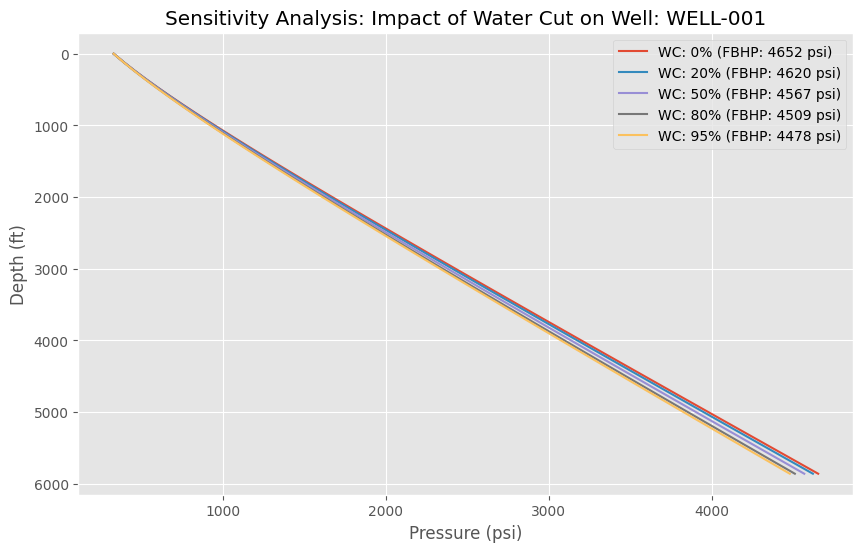

In [9]:
# 3. Sensitivity Analysis: Water Cut Impact
# As a reservoir engineer, you know Water Cut kills flow. Let's visualize it.

water_cuts = [0, 20, 50, 80, 95] # Percent

plt.figure(figsize=(10, 6))

for wc in water_cuts:
    # Create a temporary modified well row
    temp_row = sample_well.copy()
    
    # Recalculate component rates based on new Water Cut
    total_liquid = temp_row['Qo_bpd'] + temp_row['Qw_bpd']
    temp_row['Qo_bpd'] = total_liquid * (1 - wc/100)
    temp_row['Qw_bpd'] = total_liquid * (wc/100)
    
    # Capture ALL outputs: FBHP, depth_profile (y), and pressure_profile (x)
    fbhp_res, depth_res, pressures_res = calculate_pressure_traverse(temp_row)
    
    # Plot using the matched lists returned by the function
    plt.plot(pressures_res, depth_res, label=f'WC: {wc}% (FBHP: {fbhp_res:.0f} psi)')

plt.gca().invert_yaxis() # Depth increases downwards
plt.title(f"Sensitivity Analysis: Impact of Water Cut on Well: {sample_well['Well_ID']}")
plt.xlabel("Pressure (psi)")
plt.ylabel("Depth (ft)")
plt.legend()
plt.grid(True)
plt.show()